# Import Package

In [1]:
SEED = 42

# 基本套件
from sklearn.pipeline import Pipeline
import numpy as np
import pandas as pd
import os
from datetime import datetime

# Categorical Data Transforming
import category_encoders as ce
from sklearn.impute import KNNImputer

# Change Scaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler

# 資料集切割
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import StratifiedKFold

# 特徵篩選
from mlxtend.feature_selection import SequentialFeatureSelector as SFS

# 使用模型
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
# import tensorflow as tf


# 資料視覺化
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px


# 最佳化參數
import optuna

os.getcwd()

C:\Users\USER\anaconda3\envs\tensorflow_new\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


'C:\\Users\\USER\\Desktop\\Kev\\碩一\\人工智慧\\HW2'

In [2]:
import tensorflow as tf
np.random.seed(42)  # 指定亂數種子

# Read data

In [3]:
df = pd.read_csv(r'./train.csv')
print('view the data shape', df.shape)
df.head()

view the data shape (10108, 9)


,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
0,0,2008/9/30,Female,Service,No,2,3.0,3.8,0.16
1,1,2008/11/30,Male,Service,Yes,1,2.0,5.0,0.36
2,2,2008/3/10,Female,Product,Yes,2,NaN,5.8,0.49
3,3,2008/11/3,Male,Service,Yes,1,1.0,2.6,0.20
4,4,2008/7/24,Female,Service,No,3,7.0,6.9,0.52


In [4]:
# elliminate traget not na
df = df[df['Burn Rate'].notna()]

In [5]:
df = df[df.columns[1:]]
X = df[df.columns[:-1]]
y = df[df.columns[-1]]

C:\Users\USER\AppData\Local\Temp\ipykernel_23864\58359773.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<AxesSubplot: >

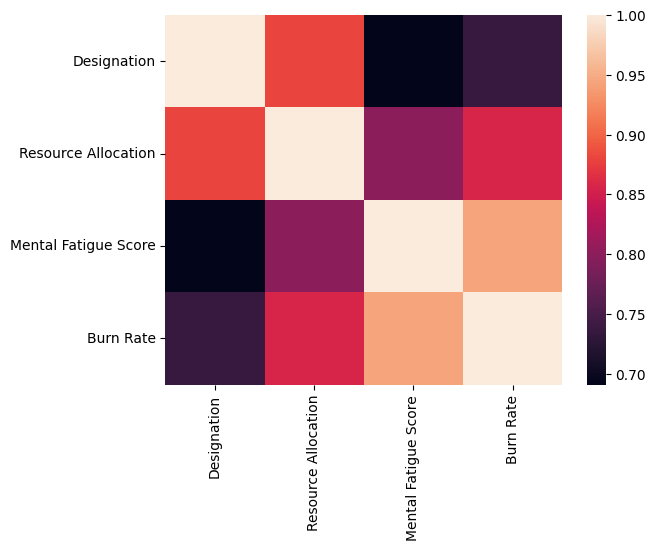

In [6]:
sns.heatmap(df.corr())

In [7]:
df.describe()

,Designation,Resource Allocation,Mental Fatigue Score,Burn Rate
count,9624.000000,9041.000000,8738.000000,9624.000000
mean,2.183292,4.500055,5.731231,0.452351
std,1.141031,2.051501,1.921508,0.198787
min,0.000000,1.000000,0.000000,0.000000
25%,1.000000,3.000000,4.600000,0.320000
50%,2.000000,4.000000,5.900000,0.450000
75%,3.000000,6.000000,7.100000,0.590000
max,5.000000,10.000000,10.000000,1.000000


# Data Preprocessing

## Transfer Time related Data

In [8]:
def transfer_date(date):
    date_format = "%Y/%m/%d"
    a = datetime.strptime('2022/10/10', date_format)
    b = datetime.strptime(date, date_format)
    delta = a - b
    return delta.days

In [9]:
X['Date of Joining'] = X['Date of Joining'].apply(lambda x : transfer_date(x))

C:\Users\USER\AppData\Local\Temp\ipykernel_23864\1446608504.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X['Date of Joining'] = X['Date of Joining'].apply(lambda x : transfer_date(x))


## Categorical Data Transforming -  Target Encoder

In [10]:
## 原類別型
ce_leave = ce.LeaveOneOutEncoder(cols = ['Gender','Company Type','WFH Setup Available'], handle_unknown='value')
ce_leave.fit(X, y)     
X = ce_leave.transform(X)

## Normalize Data

In [11]:
# Normalization
Normalize_scaler = StandardScaler()
X = pd.DataFrame(Normalize_scaler.fit_transform(X), columns=X.columns, index=X.index)

## Fill Missing Value - KNN Imputer

In [12]:
X.isna().sum()

Date of Joining           0
Gender                    0
Company Type              0
WFH Setup Available       0
Designation               0
Resource Allocation     583
Mental Fatigue Score    886
dtype: int64

In [13]:
# TODO
imputer = KNNImputer(n_neighbors=5)
X = pd.DataFrame(imputer.fit_transform(X),columns = X.columns)

In [14]:
X.isna().sum()

Date of Joining         0
Gender                  0
Company Type            0
WFH Setup Available     0
Designation             0
Resource Allocation     0
Mental Fatigue Score    0
dtype: int64

In [15]:
X.reset_index(drop=True,inplace=True)
y.reset_index(drop=True,inplace=True)

# EDA

<AxesSubplot: >

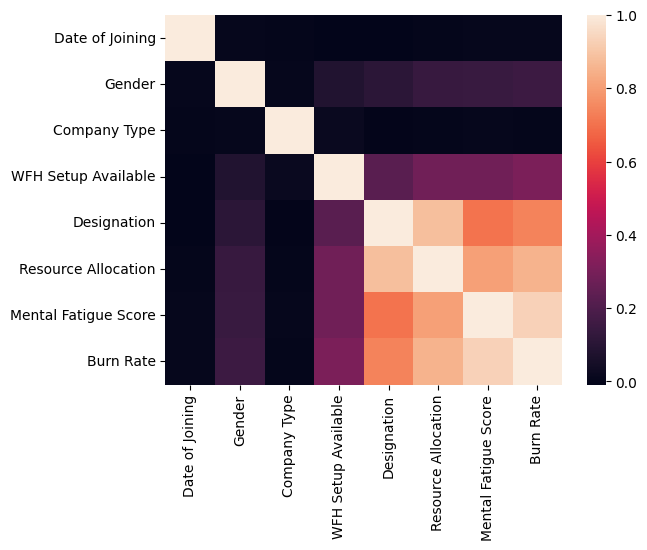

In [16]:
df = pd.concat([X,y],axis=1)
sns.heatmap(df.corr())

# Feature Selection

<AxesSubplot: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

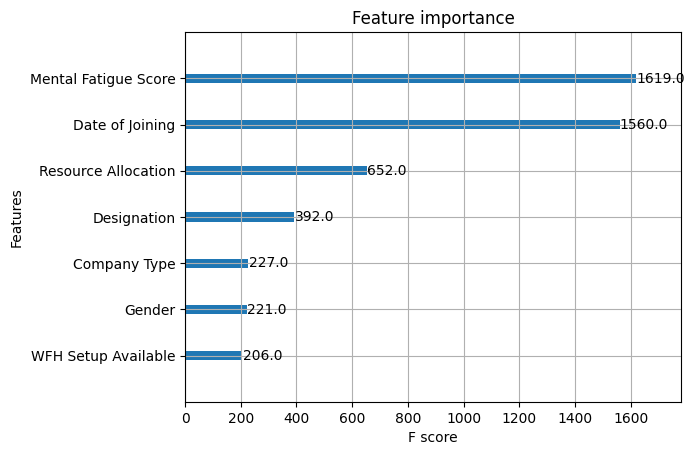

In [17]:
mode_xgb = xgb.XGBRegressor()
mode_xgb.fit(X,y)
xgb.plot_importance(mode_xgb)

Text(0.5, 0, 'Feature Importance')

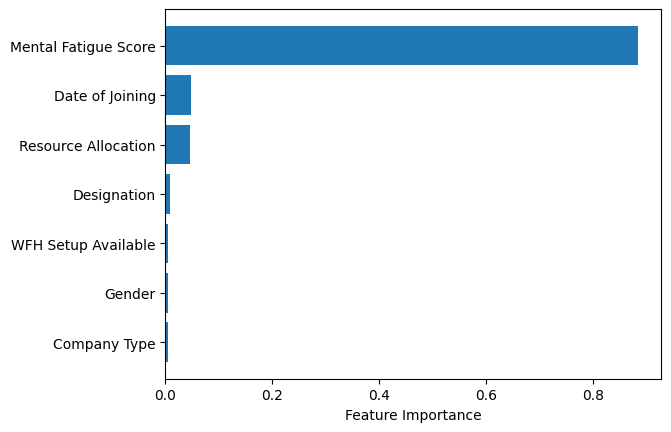

In [18]:
rf = RandomForestRegressor(n_estimators=150)
rf.fit(X, y)
sort = rf.feature_importances_.argsort()
plt.barh(X.columns[sort], rf.feature_importances_[sort])
plt.xlabel("Feature Importance")

In [19]:
df.columns

Index(['Date of Joining', 'Gender', 'Company Type', 'WFH Setup Available',
       'Designation', 'Resource Allocation', 'Mental Fatigue Score',
       'Burn Rate'],
      dtype='object')

In [20]:
# TODO
X = X.loc[:,~X.columns.isin(['WFH Setup Available', 'Company Type','Gender'])]

# Modeling

## Hypterparameter tuning - Optuna

In [21]:
# #optuna to set the hyperparameter of XGBoost
# def objective_xgb(trial):
    
#     param = {
#         'max_depth': trial.suggest_int('max_depth', 6, 15),
#         "subsample": trial.suggest_float("subsample", 0.2, 1.0),
#         'n_estimators': trial.suggest_int('n_estimators', 500, 2000, 100),
#         'eta': trial.suggest_float("eta", 1e-8, 1.0, log=True),
#         'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
#         'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
#         'gamma': trial.suggest_float("gamma", 1e-8, 1.0, log=True),
#         'min_child_weight': trial.suggest_int('min_child_weight', 2, 10),
#         'grow_policy': trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
#         "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0)
#     }
#     model = xgb.XGBRegressor(**param,tree_method='gpu_hist',random_state=SEED).fit(X_train,y_train['Burn Rate'])
#     y_pred = model.predict(X_valid)
#     pred_list = y_pred.tolist()
#     act_list = y_valid['Burn Rate'].tolist()

#     error_list = []   
#     for i in range(0, len(y_pred)):
#         error_list.append(abs(round(act_list[i] - pred_list[i], 4)))
#     abs_error_list_r4 =  [abs(ele) for ele in error_list]
    
#     return sum(abs_error_list_r4)/len(abs_error_list_r4)

In [22]:
# 分成不同盒子 - 分層抽樣用
def get_box(df):
    Y1_list = []
    for Y1 in df['Burn Rate']: 
        if (Y1 > np.percentile(df['Burn Rate'], 80)):
            Y1_list.append('3')
        elif (Y1 < np.percentile(df['Burn Rate'], 20)):
            Y1_list.append('2')
        else:
            Y1_list.append('1')
    df['box'] = Y1_list
    return df

In [23]:
# # 分層抽樣因子
# df = get_box(df)

# X = df[df.columns[:-2]]
# y = df[df.columns[-2:]]

# X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y['box'])

## Training (model construction)

In [24]:
import tensorflow as tf
import keras_tuner as kt
print(tf.__version__)
print(kt.__version__)

2.10.0
1.1.3


In [25]:
!pip install -q -U keras-tuner
from keras_tuner import HyperModel

class RegressionHyperModel(HyperModel):
    def __init__(self, input_shape):
        self.input_shape = input_shape
    def build(self, hp):
        model = tf.keras.Sequential()
        
        #1
        model.add(tf.keras.layers.Dense(
                units=hp.Int('units', 2, 10, 1, default=5),
                activation='relu',
                input_shape=input_shape))
        model.add(
            tf.keras.layers.Dropout(
                hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.2,
                    step=0.1)))      
        model.add(tf.keras.layers.BatchNormalization())
        
        #2
        model.add(tf.keras.layers.Dense(
                units=hp.Int('units',2, 10, 1, default=5),
                activation='relu'))    
        model.add(
            tf.keras.layers.Dropout(
                hp.Float(
                    'dropout',
                    min_value=0.0,
                    max_value=0.5,
                    default=0.2,
                    step=0.1)))
        model.add(tf.keras.layers.BatchNormalization())
        model.add(tf.keras.layers.Dense(1))
        
        model.compile(
            optimizer='adam',loss='mae',metrics=['mae'])
        
        return model

In [26]:
input_shape = (4,)
hypermodel = RegressionHyperModel(input_shape)

## Random Search

In [27]:
# tuner_rs = kt.RandomSearch(
#             hypermodel,
#             objective='mae',
#             seed=42,
#             overwrite=True,
#             max_trials=10,
#             executions_per_trial=2,
#             directory='random search')

In [28]:
# tuner_rs.search(X, y, epochs=50, validation_split = 0.2, verbose=1)

In [29]:
# best_model_rs = tuner_rs.get_best_models(num_models=1)[0]

## Hyperband

In [30]:
tuner_hb = kt.Hyperband(
            hypermodel,
            max_epochs=10,
            objective='mae',
            seed=42,
            overwrite=True,
            directory='hyperband')

In [31]:
tuner_hb.search(X, y, epochs=50, validation_split = 0.2, verbose=1)

Trial 30 Complete [00h 00m 12s]
mae: 0.12402966618537903

Best mae So Far: 0.06164402514696121
Total elapsed time: 00h 02m 35s
INFO:tensorflow:Oracle triggered exit


In [32]:
best_model_hb = tuner_hb.get_best_models(num_models=1)[0]
# best_model_hb.evaluate(X_valid, y_valid['Y1'])

## Bayesian 

In [ ]:
tuner_bo = kt.BayesianOptimization(
            hypermodel,
            objective='mae',
            max_trials=10,
            seed=42,
            overwrite=True,
            executions_per_trial=2,
            directory='bayesian optimization')

In [ ]:
tuner_bo.search(X_train, y_train['Y1'], epochs=50, validation_split = 0.2, verbose=1)

# Prediction
1. read data
2. model prediction
3. to_csv

In [33]:
df_test = pd.read_csv(r'./test.csv')
print(df_test.shape)
df_test.head()

(1980, 8)


,Employee ID,Date of Joining,Gender,Company Type,WFH Setup Available,Designation,Resource Allocation,Mental Fatigue Score
0,0,2008/11/12,Male,Service,Yes,0,1.0,0.0
1,1,2008/3/11,Male,Product,No,3,8.0,7.9
2,2,2008/4/3,Male,Service,No,4,9.0,8.1
3,3,2008/10/1,Male,Product,No,1,3.0,5.7
4,4,2008/1/5,Female,Service,No,3,5.0,NaN


In [34]:
X_test = df_test[df_test.columns[1:]]

## Data Preprocessing for testing

## Transfer Time related Data

In [35]:
def transfer_date(date):
    date_format = "%Y/%m/%d"
    a = datetime.strptime('2022/10/10', date_format)
    b = datetime.strptime(date, date_format)
    delta = a - b
    return delta.days

In [37]:
X_test['Date of Joining'] = X_test['Date of Joining'].apply(lambda x : transfer_date(x))

C:\Users\USER\AppData\Local\Temp\ipykernel_23864\345012162.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['Date of Joining'] = X_test['Date of Joining'].apply(lambda x : transfer_date(x))


## Categorical Data Transforming -  Target Encoder

In [38]:
## 原類別型
X_test = ce_leave.transform(X_test)

## Normalize Data

In [39]:
# Normalization
X_test = pd.DataFrame(Normalize_scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

## Fill Missing Value - KNN Imputer

In [40]:
X_test.isna().sum()

Date of Joining           0
Gender                    0
Company Type              0
WFH Setup Available       0
Designation               0
Resource Allocation     110
Mental Fatigue Score    186
dtype: int64

In [41]:
X_test = pd.DataFrame(imputer.transform(X_test),columns = X_test.columns)

## Predict Testing set

In [42]:
# TODO
X_test = X_test.loc[:,~X_test.columns.isin(['WFH Setup Available', 'Company Type','Gender'])]

In [44]:
checkpoint = tf.keras.callbacks.EarlyStopping(patience=10, monitor='val_loss')
callbacks_list = [checkpoint]

In [45]:
history_hb = best_model_hb.fit(X, y, epochs=500, batch_size=32, validation_split = 0.2, callbacks=callbacks_list)

Epoch 1/500
241/241 [==============================] - 2s 6ms/step - loss: 0.0620 - mae: 0.0620 - val_loss: 0.0520 - val_mae: 0.0520
Epoch 2/500
241/241 [==============================] - 1s 5ms/step - loss: 0.0616 - mae: 0.0616 - val_loss: 0.0518 - val_mae: 0.0518
Epoch 3/500
241/241 [==============================] - 1s 5ms/step - loss: 0.0609 - mae: 0.0609 - val_loss: 0.0517 - val_mae: 0.0517
Epoch 4/500
241/241 [==============================] - 1s 5ms/step - loss: 0.0616 - mae: 0.0616 - val_loss: 0.0518 - val_mae: 0.0518
Epoch 5/500
241/241 [==============================] - 1s 5ms/step - loss: 0.0613 - mae: 0.0613 - val_loss: 0.0503 - val_mae: 0.0503
Epoch 6/500
241/241 [==============================] - 1s 5ms/step - loss: 0.0610 - mae: 0.0610 - val_loss: 0.0501 - val_mae: 0.0501
Epoch 7/500
241/241 [==============================] - 1s 4ms/step - loss: 0.0609 - mae: 0.0609 - val_loss: 0.0499 - val_mae: 0.0499
Epoch 8/500
241/241 [==============================] - 1s 4ms/step - 

In [46]:
y_pred = best_model_hb.predict(X_test)

62/62 [==============================] - 0s 2ms/step


In [48]:
y_pred

array([[-0.05578294],
       [ 0.7098317 ],
       [ 0.74825215],
       ...,
       [ 0.32495973],
       [ 0.5522934 ],
       [ 0.47835886]], dtype=float32)

In [49]:
y_pred_output = []
for i in y_pred:
    if i<0:
        y_pred_output.append(0)
    elif i>1:
        y_pred_output.append(1)
    else:
        y_pred_output.append(i)
        
y_pred_output = pd.DataFrame(y_pred_output,columns=['Burn Rate'])

# Output .csv for submission

In [50]:
df_ans = pd.DataFrame(y_pred_output.astype(float), columns=['Burn Rate'])
df_ans.to_csv('mySubmission.csv', index_label='Employee ID')

In [51]:
df_ans

,Burn Rate
0,0.000000
1,0.709832
2,0.748252
3,0.412237
4,0.468639
...,...
1975,0.174063
1976,0.452137
1977,0.324960
1978,0.552293
